### Author: Frederick Tan
### Student ID: 16227617
### Assignment Number: 5

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as py
import tabulate
from bs4 import BeautifulSoup
from pylab import rcParams
from IPython.display import HTML, display

%matplotlib inline
matplotlib.style.use('ggplot')

# Introduction

From the assignment description: "Given an N-dimensional sphere of radius, r, centred at the origin of an
N-dimensional coordinate system, first complete a sequential function to
count the number of integer coordinate points inside the sphere. "

# System Configuration

The important configuration regarding the GPU on the test machine is described below:

In [ ]:
table = [['GPU Card', 'Quadro K600'],
         ['CUDA Driver Version', '10.0'],
         ['Runtime Version', '10.0'],
         ['CUDA Capability Version', '3.0'],
         ['Global memory', '980 MBytes'],
         ['Processor', '1'],
         ['CUDA Cores/MP', '192'],
         ['Amount of shared memory per block', '49152 bytes'],
         ['Maximum number of threads per multiprocessor', '2048'],
         ['Maximum number of threads per block', '1024'],
         ['Max dimension size of a thread block (x,y,z)', '(1024, 1024, 64)'],
         ['Max dimension size of a grid size (x,y,z)', '(2147483647, 65535, 65535)']]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

# Code Implementation

The base code used for the GPU implementation is the first approach, using a 'convert' function. The author thought it was easier to model into a GPU program.

There were a number of design iterations during the whole process. Among the factors which affected the design are:
* What part of the code to parallelize?
    * During the initial version, blocks were used to model the total number of points and the thread id per block was used to represent the dimensions
* GPU Global memory
    * Limits the array size that can be created
* The CUDA capability version
    * The laboratory machine has a CUDA capability version 2.0, which does not support the atomicAdd operation for long
    * This impacts the number of points that can be processed as this is the original data type for count
    * One solution is to use arrays and indexing
    * The machine which was finally used has a capability version 3.0, good enough to support atomicAdd for long
* How many application are using the GPU
    * This has an impact on where you can run your code
    * As there are a number of threads used by the kernel program, it takes time for the GPU to return
    * The GPU watchdog kicks in (because the GPU is also used by other host level application, e.g., the display)
    * To solve the watchdog issue, the test was done through Linux runlevel 3, which means there are no other host applications using the GPU, and in turn means "unlimited" resources for the GPU program
    
In the end, it was decided to design the while loop inside the original convert function as running in one thread, with the justification that the maximum number of dimensions is 10, which is negligible compared to the number of points.

For testing purposes, the number of threads is made configurable to see the effect of having more threads, and consequently, lesser blocks.


# Processing the Data

In [2]:
df_parallel_1 = pd.read_csv('./result.v4.last/result.full_v4', 
                          names=['Radius', 'NDim', 'NTotal', 'NThread', 'Count',
                                 'TotalTime', 'CopyFromHostTime', 'CopyFromDeviceTime'])
df_parallel_2 = pd.read_csv('./result.v4.7_8/result.full_v4', 
                          names=['Radius', 'NDim', 'NTotal', 'NThread', 'Count',
                                 'TotalTime', 'CopyFromHostTime', 'CopyFromDeviceTime'])

In [3]:
df_base_1 = pd.read_csv('./result/result.base', names=['Radius', 'NDim', 'NTotal',
                                                     'TotalTimeV1', 'TotalTimeV2'])
df_base_2 = pd.read_csv('./result_v3_7_8/result.base', names=['Radius', 'NDim', 'NTotal',
                                                     'TotalTimeV1', 'TotalTimeV2'])

In [4]:
df_parallel = pd.concat([df_parallel_1, df_parallel_2]).reset_index(drop=True)
df_base = pd.concat([df_base_1, df_base_2]).reset_index(drop=True)

## Figure 1.1: Control v.s. GPU with Different Thread Numbers

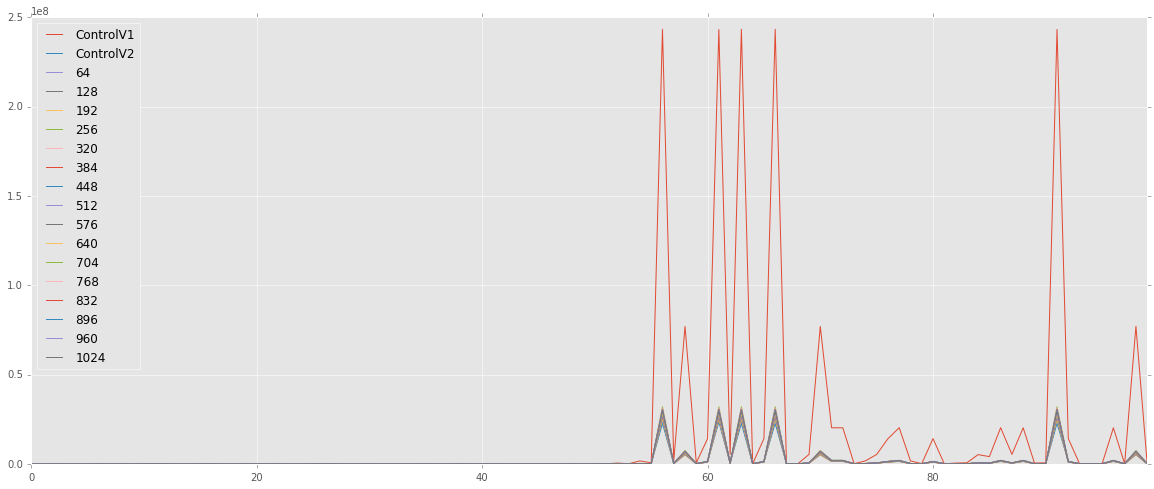

In [7]:
fig, ax = plt.subplots(figsize=(20,8))

df_base.plot(y='TotalTimeV1', label='ControlV1', ax=ax)
df_base.plot(y='TotalTimeV2', label='ControlV2', ax=ax)
for nth in df_parallel.NThread.unique():
    df_parallel[df_parallel.NThread == nth].reset_index(drop=True).plot(y='TotalTime', label=nth, ax=ax)

## Figure 1.2: GPU Performance with Different Thread Numbers

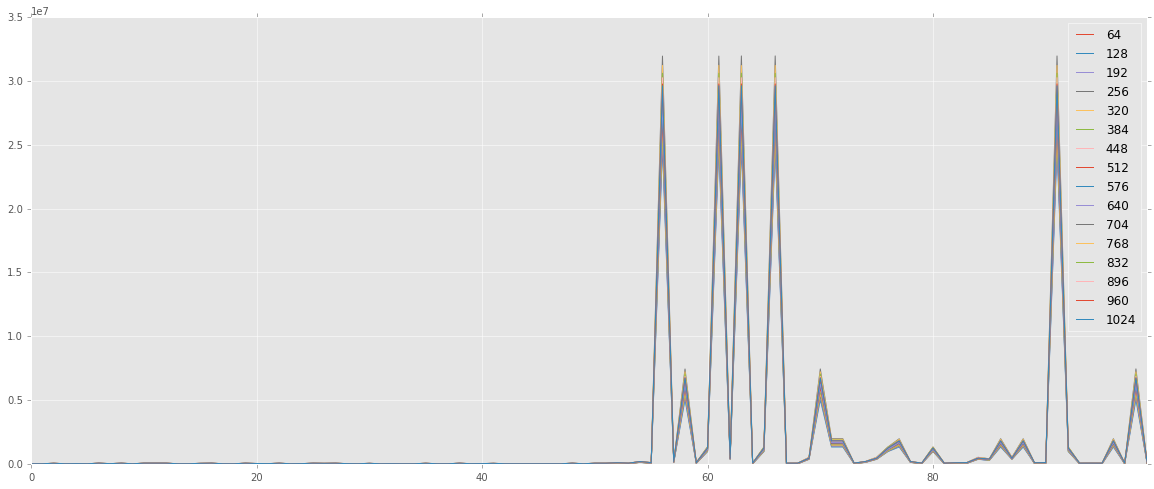

In [8]:
fig, ax = plt.subplots(figsize=(20,8))

for nth in df_parallel.NThread.unique():
    df_parallel[df_parallel.NThread == nth].reset_index(drop=True).plot(y='TotalTime', label=nth, ax=ax)

## Figure 1.3: Thread Performance Ranking

In [9]:
df_parallel.groupby(
    'NThread').mean().drop(
    ['Radius', 'NTotal', 'CopyFromHostTime', 'CopyFromDeviceTime',
     'NDim', 'Count'],
     axis=1).rank().sort_values(
     by='TotalTime').reset_index().rename(columns={'TotalTime' : 'TotalTimeRank'}).set_index('TotalTimeRank')

NThread
TotalTimeRank         
1                  128
2                  192
3                  256
4                  320
5                  384
6                  448
7                  512
8                  576
9                  640
10                  64
11                1024
12                 960
13                 896
14                 832
15                 768
16                 704

# Analysis and Conclusion

The performance of controlled version 1 is really bad compared to version 2.

For parallel implementation, from the author's perspective, version 1 is easier to parallelize. Therefore, this approach was adopted.

As mentioned in the Code Implementation section above, the points were modeled as threads. Due to the resource requirements of the solution, it was tested using Linux runlevel 3, ensuring it can use almost all of the GPU resources.

The number of threads have negligible effect on the result, which is a great contrast to the threading using OpenMP and the host CPU. For GPUs, the performance of the threads regardless of the configuration, is consistent.

Another important point when designing a CUDA program is the capability of the GPU card. With the higher capability version, there are useful features that can make the implementation more efficient. One example is the atomicAdd which has a support for long parameters in 3.0, and is missing in 2.0. This helps by not making use of the memory, which is the alternative solution, by declaring long arrays and passing it between host and device.

Another technique that can be useful is learning how to divide your kernel functions into smaller chuncks, which can help avoid the GPU watchdog. This was used in one of my earlier versions.

### Average Time to Copy from the Device

In [12]:
df_parallel.CopyFromDeviceTime.mean()

18.3475

### Average Time to Copy to the Device

In [13]:
df_parallel.CopyFromHostTime.mean()

12.0525